# Using Deep Learning to "learn" the images of earthquake audio data.

I wanted to expand my knowledge of deep learning and specifically using fastai. This kernel explores how I converted the acoustic data from the LANL Earthquake competition into melspectogram images. After converting audio to images we can train an image regression model using the fastai library.

So far I haven't been able to get outstanding performance out of this approach, but I am new to deep learning and the fastai/pytorch library. Hopefully this will be helpful for others interested in learning more about deep learning.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import librosa.display
from librosa.feature import melspectrogram
import librosa
import random
from tqdm import tqdm_notebook
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Loading the training labels and exploring the images

In [ ]:
# Train labels can be found in this CSV
train_labels = pd.read_csv('../input/lanl-earthquake-spectrogram-images/training_labels.csv')
train_labels.head()

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))
img1 = mpimg.imread('../input/lanl-earthquake-spectrogram-images/train_images_no_overlap/train_images_v3/train_0.png')
img2 = mpimg.imread('../input/lanl-earthquake-spectrogram-images/train_images_no_overlap/train_images_v3/train_100.png')
img3 = mpimg.imread('../input/lanl-earthquake-spectrogram-images/train_images_no_overlap/train_images_v3/train_200.png')
img4 = mpimg.imread('../input/lanl-earthquake-spectrogram-images/train_images_no_overlap/train_images_v3/train_300.png')
img5 = mpimg.imread('../input/lanl-earthquake-spectrogram-images/train_images_no_overlap/train_images_v3/train_400.png')
ax1.imshow(img1)
ax1.set_title('TTF - {:0.4f}'.format(train_labels.loc[train_labels['seg_id'] == 'train_0']['target'].values[0]), fontsize=25)
ax2.imshow(img2)
ax2.set_title('TTF - {:0.4f}'.format(train_labels.loc[train_labels['seg_id'] == 'train_100']['target'].values[0]), fontsize=25)
ax3.imshow(img3)
ax3.set_title('TTF - {:0.4f}'.format(train_labels.loc[train_labels['seg_id'] == 'train_200']['target'].values[0]), fontsize=25)
ax4.imshow(img4)
ax4.set_title('TTF - {:0.4f}'.format(train_labels.loc[train_labels['seg_id'] == 'train_300']['target'].values[0]), fontsize=25)
ax5.imshow(img5)
ax5.set_title('TTF - {:0.4f}'.format(train_labels.loc[train_labels['seg_id'] == 'train_400']['target'].values[0]), fontsize=25)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax5.axis('off')
plt.tight_layout()
plt.show()

## Example of how the images were created
- We use the `librosa` package which converts audio into melspectograms.
- I tweaked the sample rate `sr` number of mels `n_mels` and used a log scale `power_to_db`. The values I chose were mainly based off of what I thought made the images look unique and detailed. A more scientific approach to creating the melspectrograms may yield better results.


In [35]:
seg_00030f = pd.read_csv('../input/LANL-Earthquake-Prediction/test/seg_00030f.csv')
y = seg_00030f['acoustic_data'].astype('float').values

In [36]:
def plot_spectrogram(y, imgdir=None, imgname=None, plot=True, sr=10000, n_mels=1000, log_tf=True, vmin=-100, vmax=0):
    # Let's make and display a mel-scaled power (energy-squared) spectrogram
    #y = np.array([float(x) for x in df['acoustic_data'].values])
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=n_mels)

    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    if log_tf:
        S = librosa.power_to_db(S, ref=np.max)
    
    if plot:
        # Make a new figure
        plt.figure(figsize=(15,5))
        plt.imshow(S)
        # draw a color bar
        plt.colorbar(format='%+02.0f dB')
        # Make the figure layout compact
        plt.tight_layout()
        plt.axis('off')
    if imgname is not None:
        plt.imsave('{}/{}.png'.format(imgdir, imgname), S)
        plt.clf()
        plt.close()
    return

In [ ]:
# Plot an example using this function.
plot_spectrogram(y)

# Modeling with Fastai Library
https://www.fast.ai/ is a great resource for those interested in learning more about deep learning. After watching a few of the fastai tutorial videos I felt comfortable creating a baseline model.

In [39]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# I personally hate that fastai encourages using `import *`
# That is how it is taught in the course
from fastai import *
from fastai.vision import *

## Create a fastai databunch of training images and labels.
- You can use a random split, or provide train and valid indexes for determining the train/valid split.
- I disabled transforms on the image but this may be useful when doing transfer learning.
- label_cls must be set to FloatList as we are using the images to predict a float number (Time to failure)

In [42]:
bs = 10
train_labels['path'] = '../input/lanl-earthquake-spectrogram-images/train_images_no_overlap/train_images_v3/' + train_labels['seg_id'] + '.png'
#valid_idx = train_labels[:10000].loc[train_labels['quake_number'].isin([1, 5, 8])].index
#train_idx = train_labels[:10000].loc[~train_labels['quake_number'].isin([1, 5, 8])].index
data = (ImageList.from_df(train_labels[:-1], path='./', cols='path')
        #.split_by_idxs(train_idx=train_idx, valid_idx=valid_idx)
        .split_by_rand_pct(0.1)
        .label_from_df('target', label_cls=FloatList)
        #.transform(get_transforms(), size=255)
        .databunch(bs=bs))

## Checking the images in a databunch batch

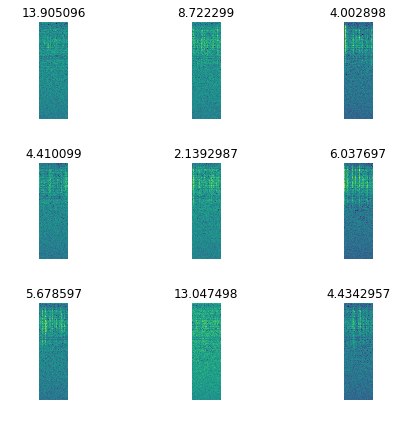

In [43]:
data.show_batch(rows=3, figsize=(7,6))

# Create the Fastai resnet50 model
- Make sure you have GPU turned on or this will be very slow.
- We are using mean_absolute_error as our evaluation metric

In [46]:
def mean_absolute_error(pred:Tensor, targ:Tensor)->Rank0Tensor:
    "Mean absolute error between `pred` and `targ`."
    pred,targ = flatten_check(pred,targ)
    return torch.abs(targ - pred).mean()

learn = cnn_learner(data, models.resnet50, metrics=mean_absolute_error)
learn.fit_one_cycle(4, 0.01)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,10.691886,9.303072,2.388052,01:40
1,10.180142,11.678172,2.665515,01:39
2,8.405375,7.858608,2.270359,01:40
3,7.949627,6.747758,2.059102,01:39


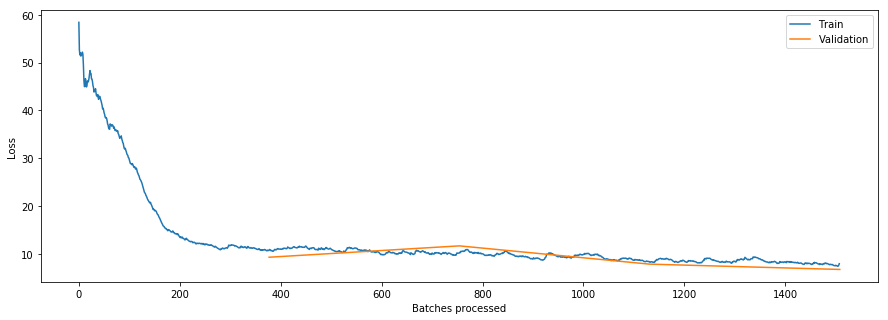

In [76]:
# Plot train vs valid loss
fig = learn.recorder.plot_losses(return_fig=True)
fig.set_size_inches(15,5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


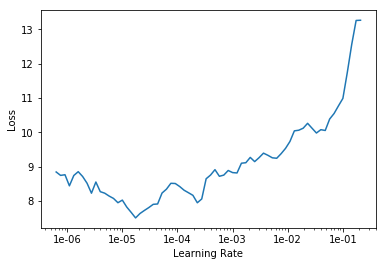

In [77]:
# Unfreeze the model and search for a good learning rate
learn.unfreeze()
learn.lr_find()
fig = learn.recorder.plot(return_fig=True)
fig.set_size_inches(15,5)

In [78]:
learn.fit_one_cycle(2, slice(1e-6, 3e-3/10))
learn.save('cnn-step1')

epoch,train_loss,valid_loss,mean_absolute_error,time
0,7.592947,6.739468,2.054890,02:09
1,8.003979,6.931798,2.085333,02:09


In [81]:
# Export the model
learn.export()

In [85]:
# We can see there is now an export.pkl file that we've saved
!ls -l

total 100656
-rw-r--r-- 1 root root    136875 May  8 17:30 __notebook_source__.ipynb
-rw-r--r-- 1 root root 102817372 May  8 17:37 export.pkl
drwxr-xr-x 2 root root      4096 May  8 17:35 models


Validation MAE ~ 2.08 isn't that great and we are starting to overfit. Using a better cross validation technique may be necessary.

I'm sure you can do better than I have here, but this should be enough to get you started.

# Predicting on the test set
- We load our sample submission file and create an imagelist based off of the seg_id
- We point this imagelist at the images we've creates for the test set.
- Load the trained model and call the prediction method on this imagelist.

In [86]:
ss = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv')
test = ImageList.from_df(ss, '../input/lanl-earthquake-spectrogram-images/test_images/test_images_v3/', cols='seg_id', suffix='.png')
learn = load_learner('./', test=test)
learn.load('cnn-step1')
preds = learn.get_preds(ds_type=DatasetType.Test)

In [87]:
# Save the time to failure
ss['time_to_failure'] = [float(x) for x in preds[0]]

In [88]:
ss.head()

,seg_id,time_to_failure
0,seg_00030f,4.873120
1,seg_0012b5,4.994225
2,seg_00184e,5.322777
3,seg_003339,9.331327
4,seg_0042cc,6.957149


In [98]:
# Cap the minimum and maximum time to failure values
ss.loc[ss['time_to_failure'] < 0, 'time_to_failure'] = 0
ss.loc[ss['time_to_failure'] > 12, 'time_to_failure'] = 12

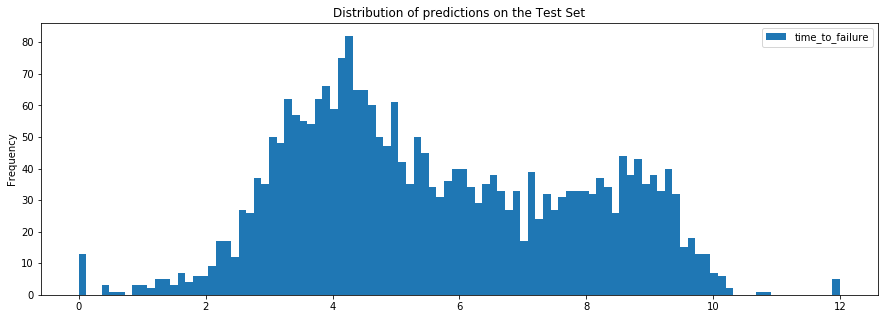

In [100]:
ss.plot(kind='hist', bins=100, figsize=(15, 5), title='Distribution of predictions on the Test Set')
plt.show()

In [102]:
# Save our predictions
ss.to_csv('submission.csv', index=False)

I hope this can be helpful to others. Please let me know if you have any suggestions on how I could improve it.